In [1]:
from yolox.exp import get_exp
import torch
from torch import nn
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from yolox.data import ValTransform
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import torchvision
%matplotlib inline
# from IPython.display import Image 

ckpt_dir='yolox_checkpoints'
exp_name = 'yolox-s'
ckpt_name='yolox_s.pth'
ckpt_path=os.path.join(ckpt_dir,ckpt_name)
device='cuda' if torch.cuda.is_available() else 'cpu'

In [2]:

exp=get_exp(exp_file=None,exp_name=exp_name)
model=exp.get_model()
model.cuda()
model.eval()
model.load_state_dict(torch.load(ckpt_path,map_location=device)['model'])
# print(model)
conf=exp.test_conf #0.01
nms=exp.nmsthre #0.65
img_size=exp.test_size # (640,640)
num_classes=exp.num_classes # 80
print(conf,nms,img_size,num_classes)

0.01 0.65 (640, 640) 80


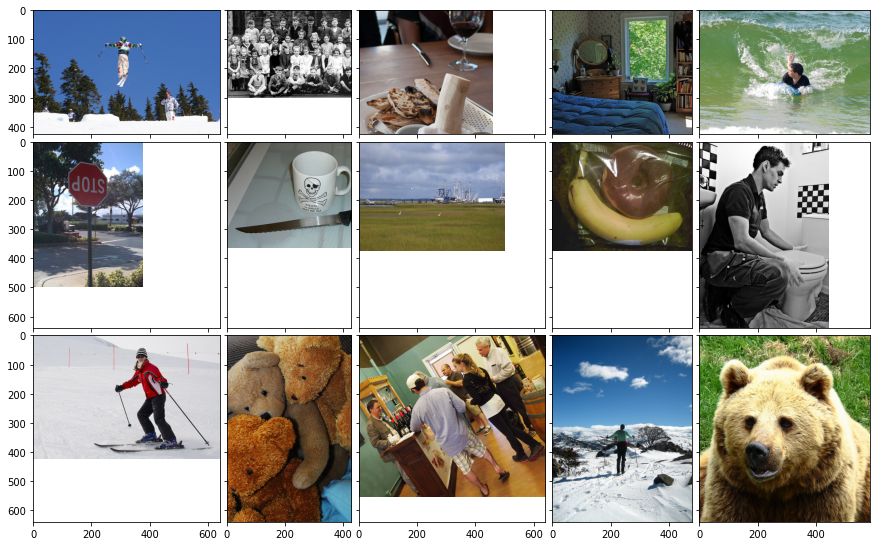

In [9]:
def load_img(img_path):
    
    def resize_img(img,img_size):
            r = min(img_size[0] / img.shape[0], img_size[1] / img.shape[1])
            resized_img = cv2.resize(
                img,
                (int(img.shape[1] * r), int(img.shape[0] * r)),
                interpolation=cv2.INTER_LINEAR,
            ).astype(np.uint8)
            return resized_img
    img=cv2.imread(img_path)
    img=resize_img(img,img_size)
    return img
def plot_imgs_grid(imgs):
    fig=plt.figure(figsize=((len(imgs)//5)*5,(len(imgs)//5)*5))
    grid=ImageGrid(fig,111,nrows_ncols=((len(imgs)//5),5),axes_pad=0.1)
    for ax,img in zip(grid,imgs):
        ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()
    return 

img_dir='test_images'

imgs=[cv2.imread(os.path.join(img_dir,img_name)) for img_name in os.listdir(img_dir)]

plot_imgs_grid(imgs)
# plt.show()

/home/hazemahmed/anaconda3/envs/yolo_env/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


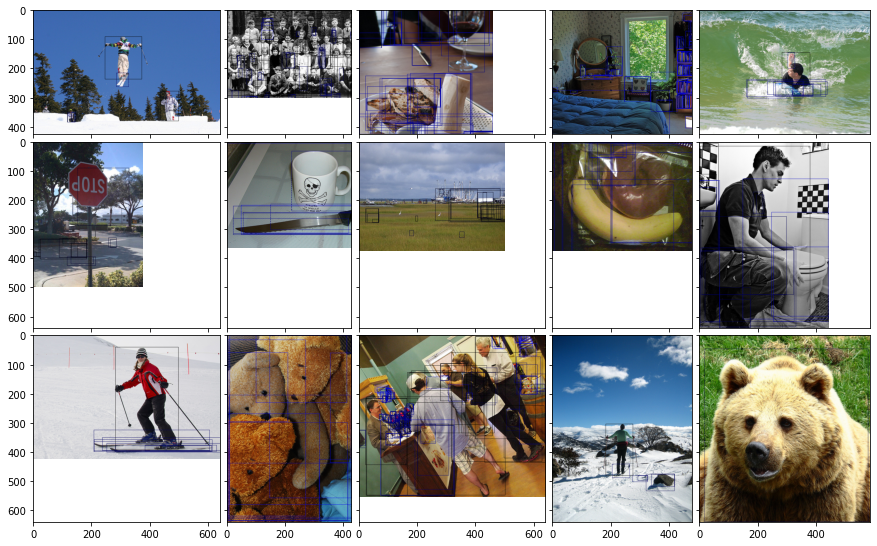

In [10]:
def postprocess(prediction, num_classes, conf_thre=0.7, nms_thre=0.45, class_agnostic=False):
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    for i, image_pred in enumerate(prediction):

        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(image_pred[:, 5: 5 + num_classes], 1, keepdim=True)

        conf_mask = (image_pred[:, 4] * class_conf.squeeze() >= conf_thre).squeeze()
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf, class_pred.float()), 1)
        detections = detections[conf_mask]
        if not detections.size(0):
            continue

        if class_agnostic:
            nms_out_index = torchvision.ops.nms(
                detections[:, :4],
                detections[:, 4] * detections[:, 5],
                nms_thre,
            )
        else:
            nms_out_index = torchvision.ops.batched_nms(
                detections[:, :4],
                detections[:, 4] * detections[:, 5],
                detections[:, 6],
                nms_thre,
            )

        detections = detections[nms_out_index]
        if output[i] is None:
            output[i] = detections
        else:
            output[i] = torch.cat((output[i], detections))

    return output
def get_bbox_prediction(model,img,preproc,postproc,img_size):
    img=img.copy()
    img,_=preproc(img=img,res=None,input_size=img_size)
    img=torch.from_numpy(np.expand_dims(img,axis=0)).cuda()
    with torch.no_grad():
        prediction=model(img)
        predictions=postproc(prediction,num_classes,conf,nms)[0].detach().cpu().numpy().tolist()

        return predictions
def vis_img_pred(img,pred_bbox):
    img=img.copy()
    colors=np.linspace(start=(0,0,0),stop=(255,0,0),num=num_classes)
    for x1,y1,x2,y2,conf_,_,c in pred_bbox:
        x1,y1,x2,y2,c=int(x1),int(y1),int(x2),int(y2),int(c)
        img=cv2.rectangle(img,(x1,y1),(x2,y2),colors[c],1)
    return img

vis_imgs=[]
for img in imgs:
    pred_bbox=get_bbox_prediction(model,img,ValTransform(),postprocess,img_size)
    # print(pred_bbox)
    # vis_img=vis_img_pred(img,pred_bbox)
    vis_imgs.append(vis_img_pred(img,pred_bbox))
# imshow(cv2.cvtColor(vis_img,cv2.COLOR_BGR2RGB))
# imshow(vis_img)
plot_imgs_grid(vis_imgs)

# Analysis

#### What do you like about it?

- easier to implement 
- i liked the yolov5 results and i was surprised that yolox surpassed it
- the anchorless approach will help remove the process of anchor clustering before every specific domin detectors

#### What do you dislike?
- it could have been a deal breaker if the anchorless and nms-free gives the SOTA performance, but no complains

#### What do you think are potential areas of improvement and what are the main contributions?
- Try the new transformer detectors with the anchorless insights
- Try the optimal transport assignment using the Sinkhorn-Knopp algorithm
- when assigning targets to predicition, choose the high quaility prediciton with the best confidence to benefit the gradients as said in the report

#### How do they differ from previous YOLO models?

1. Replaced the Yolo's head with **Decoupled Head**
2. Anchorless
3. In case of multi positive prediction, yolox uses a method called center sampling
4. yolox uses **SimOTA** for advanced label assignment
5. trained the models from scratch